# Sensitivity to resolution

This notebook recreates Figure 4 from the original publication, testing LERM's sensitivity to resolution changes.

In [1]:
import pickle
import random

import pyleoclim as pyleo
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

# Top Panel

In [3]:
#Defining group lists for easy loading
group_names = ['ODP 925']

Time axis values sorted in ascending order


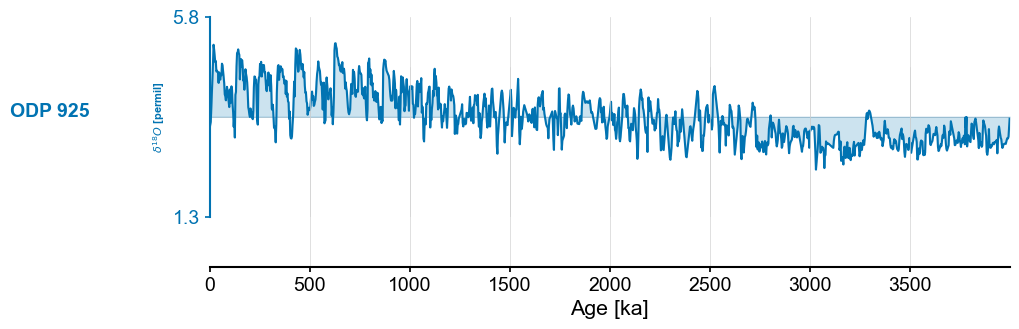

In [4]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('../data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,2*len(ms.series_list)))

In [5]:
with open('../data/0_2500_I65_staged.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [6]:
odp_series = ms.series_list[0]
binned_series = initial_series.bin(time_axis=odp_series.time) # Binning synthetic data onto the time axis of ODP 925

In [7]:
def noise_test(series,sn_ratio=1,m=13,tau=None,w_size=50,w_incre=5,find_eps_kwargs=None):
    """Run a noise test
    
    Parameters
    ----------
    
    series : pyleo.Series
        Series on which to apply noise test
        
    sn_ratio : float
        Signal to noise ratio to use.
        Note that signal to noise is defined as the standard deviation of the series 
        divided by the standard deviation of the noise
        
    m : int
        Embedding dimension
        
    tau : int
        Time delay embedding
        
    w_size : int
        Window size
        
    w_incre : int
        Window increment
        
    find_eps_kwargs : dict
        Dictionary of arguments for amt.TimeEmbeddedSeries.find_epsilon"""
    
    find_eps_kwargs = {} if find_eps_kwargs is None else find_eps_kwargs.copy()
    if 'eps' not in find_eps_kwargs:
        find_eps_kwargs['eps'] = 1

    noise_time,noise_value = pyleo.utils.gen_ts(model='ar1',t=series.time,scale=series.stats()['std']/sn_ratio) # Create AR1 series with appropriate standard deviation
    noise = pyleo.Series(noise_time,noise_value,label='Noise Series',sort_ts=None) # Create noise series
    real_sn_ratio = series.stats()['std']/noise.stats()['std'] # Calculate actual S/N ratio as sanity check
    noisy_series = series.copy()
    noisy_series.value += noise.value
    amt_series = amt.Series(
        time=noisy_series.time,
        value=noisy_series.value,
        time_name = noisy_series.time_name,
        value_name = noisy_series.value_name,
        time_unit = noisy_series.time_unit,
        value_unit = noisy_series.value_unit,
        label = noisy_series.label,
        sort_ts=None
    )
    amt_series.convert_time_unit('Years')
    td = amt_series.embed(m)
        
    eps = td.find_epsilon(**find_eps_kwargs)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(w_size=w_size,w_incre=w_incre)
    lp_series.convert_time_unit('ka')
    
    return lp_series, noisy_series, real_sn_ratio

In [8]:
sn_ratio = 2
find_eps_kwargs = {'eps':5}

# Here we use the noise_test function to carry out tests on the effect of the inclusion of noise. 
# This function uses a default embedding dimension of 13, picks tau according to the first minimum of mutual information, and uses a default window size of 50 and window increment of 5

lp_series_2,noisy_series_2,real_sn_ratio_2 = noise_test(binned_series,
                                                        sn_ratio=sn_ratio,
                                                        find_eps_kwargs=find_eps_kwargs)

NaNs have been detected and dropped.


Initial density is 0.2422
Initial density is not within the tolerance window, searching...
Epsilon: 3.0777, Density: 0.0130
Epsilon: 3.4477, Density: 0.0272
Epsilon: 3.6756, Density: 0.0417
Epsilon: 3.6756, Density: 0.0417.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='Ice Volume'>)

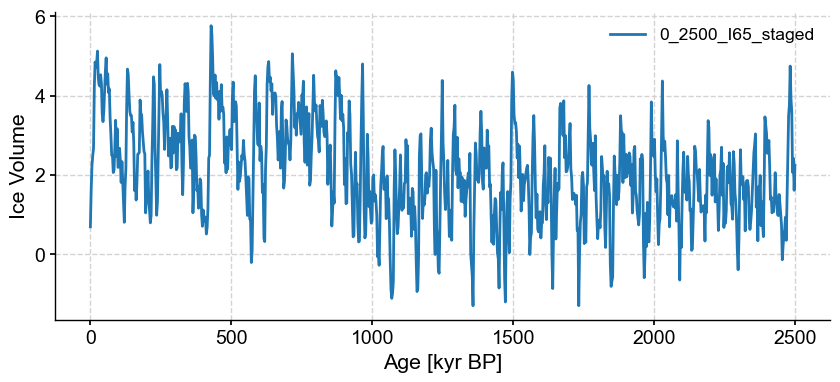

In [9]:
noisy_series_2.plot()

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='Fisher Information [None]'>)

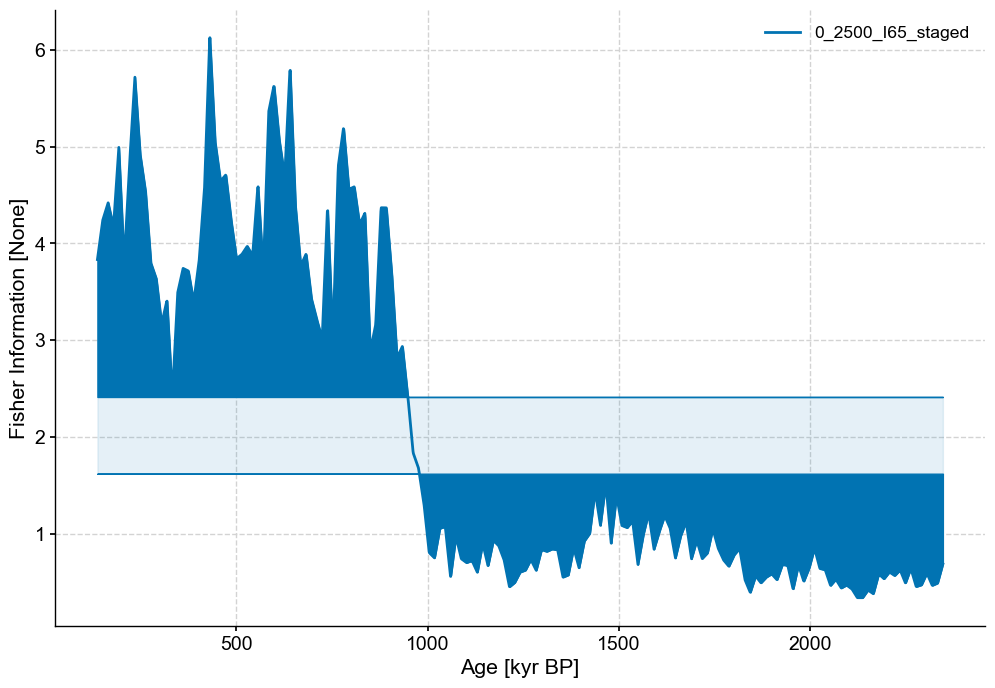

In [10]:
lp_series_2.confidence_fill_plot()

# Middle panel

In [11]:
with open('../data/0_2500_I65_stable.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [12]:
stable_series = initial_series.bin(bin_size=4)
stable_series.label = 'Stable Series'

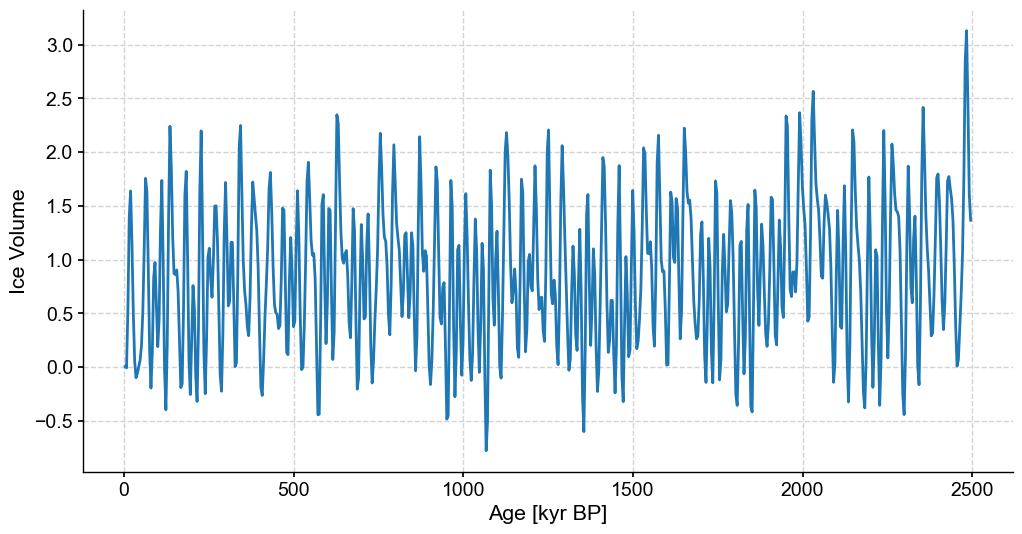

In [13]:
fig,ax = stable_series.plot(figsize=(12,6),legend=False)

In [14]:
series = stable_series
m=12 # Embedding dimension

amt_series = amt.Series(
    time=series.time,
    value=series.value,
    time_name = series.time_name,
    value_name = series.value_name,
    time_unit = series.time_unit,
    value_unit = series.value_unit,
    label = series.label,
    clean_ts=False
).convert_time_unit('Years')
td = amt_series.embed(m) # Pick tau according to first minimum of mutual info
eps = td.find_epsilon(1,.05,.01,parallelize=False) # Find epsilon that create recurrence matrix with density of 5% plus or minus 1%. Initial guess at epsilon is 1.
rm = eps['Output']
lp_stable = rm.laplacian_eigenmaps(50,5).convert_time_unit('ka') # Window size and window increment of 50 and 5 respectively

Time axis values sorted in ascending order
Initial density is 0.0022
Initial density is not within the tolerance window, searching...
Epsilon: 1.4781, Density: 0.0099
Epsilon: 1.8789, Density: 0.0401
Epsilon: 1.8789, Density: 0.0401.


Text(0.5, 0, 'Age [kyr BP]')

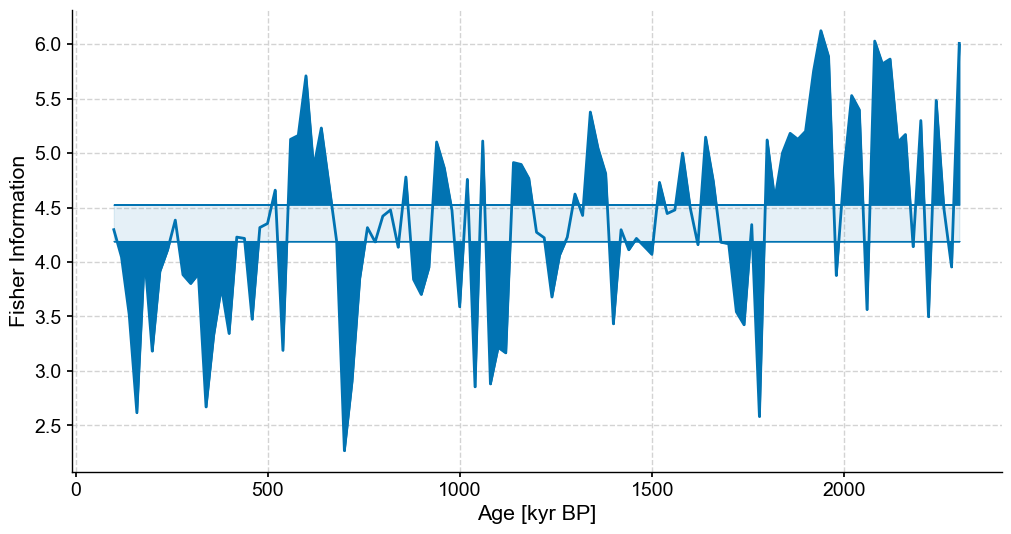

In [15]:
fig,ax = plt.subplots(figsize=(12,6))

lp_stable.confidence_fill_plot(ax=ax,legend=False)
ax.set_ylabel('Fisher Information')
ax.set_xlabel('Age [kyr BP]')

# Bottom panel

In [16]:
def remove_values(series,percent,seed=42,subset=None):
    '''Function to remove values at random
    
    Note that this currently assumes units of Years BP
    
    Parameters
    ----------
    
    series : pyleoclim.Series
        Series to remove values from
        
    percent : float
        Percentage of values to remove. Should be between 0 and 100
    
    seed : int
        Random seed to use
        
    subset : list
        [Start,stop] time indices for section of series you wish to be randomly coarsened. 
        If not passed, the whole series will be coarsened
        
    Returns
    -------
    
    sparse_series : pyleoclim.Series
    '''
    
    random.seed(seed)
    sparse_series = series.copy()
    
    if subset:
        sparse_slice = series.slice(subset)
        sparse_index = np.where((series.time >= sparse_slice.time[0]) & (series.time <= sparse_slice.time[-1]))[0]
        num_drop = int(len(sparse_slice.time) * (percent/100))
        index_drop = sorted(random.sample(range(sparse_index[0],sparse_index[-1]), num_drop))
        time = np.delete(series.time,index_drop)
        value = np.delete(series.value,index_drop)
        sparse_series.time = time
        sparse_series.value = value
        
    else:   
        num_drop = int(len(series.time) * (percent/100))
        index_drop = sorted(random.sample(range(len(series.time)), num_drop))
        time = np.delete(series.time,index_drop)
        value = np.delete(series.value,index_drop)
        sparse_series.time = time
        sparse_series.value = value
    
    return sparse_series

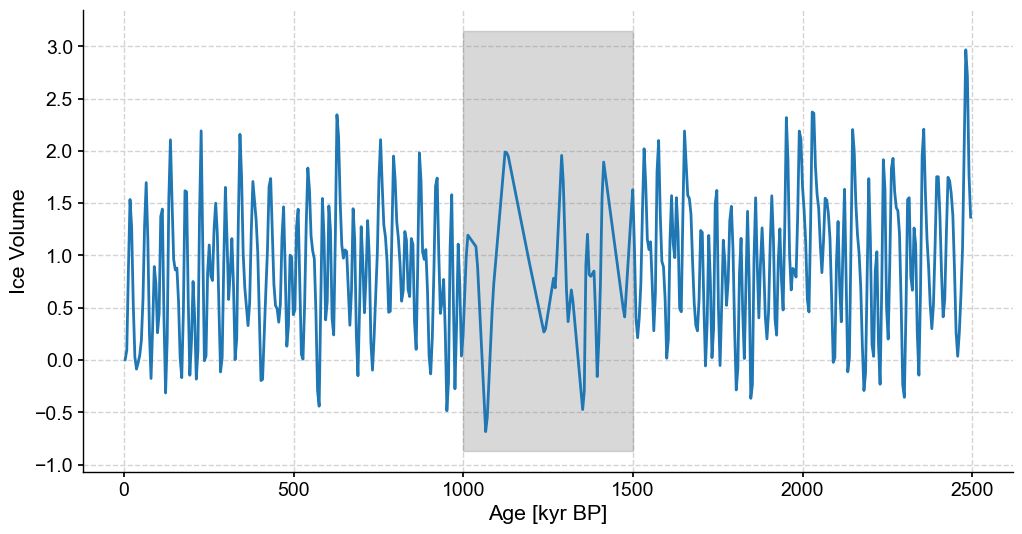

In [17]:
bounds = [1000,1500]

coarse_series = remove_values(series=stable_series,percent=80,subset=bounds).interp() #Artificially coarsening our stable synthetic data by removing 80% of values between specified bounds
fig,ax = coarse_series.plot(legend=False,figsize=(12,6))

ylim=ax.get_ylim()
ax.fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')

In [18]:
series = coarse_series.interp()
m=12

amt_series = amt.Series(
    time=series.time,
    value=series.value,
    time_name = series.time_name,
    value_name = series.value_name,
    time_unit = series.time_unit,
    value_unit = series.value_unit,
    label = series.label,
    clean_ts=False
).convert_time_unit('Years')
td = amt_series.embed(m=m)
eps = td.find_epsilon(eps=1,target_density=.05,tolerance=.01)
print(f'Tau is {td.tau}')
rm = eps['Output']
lp_coarse = rm.laplacian_eigenmaps(50,5).convert_time_unit('ka')

Time axis values sorted in ascending order
Initial density is 0.0029
Initial density is not within the tolerance window, searching...
Epsilon: 1.4708, Density: 0.0115
Epsilon: 1.8557, Density: 0.0470
Epsilon: 1.8557, Density: 0.0470.
Tau is 3


Text(0.5, 0, 'Age [Kyr BP]')

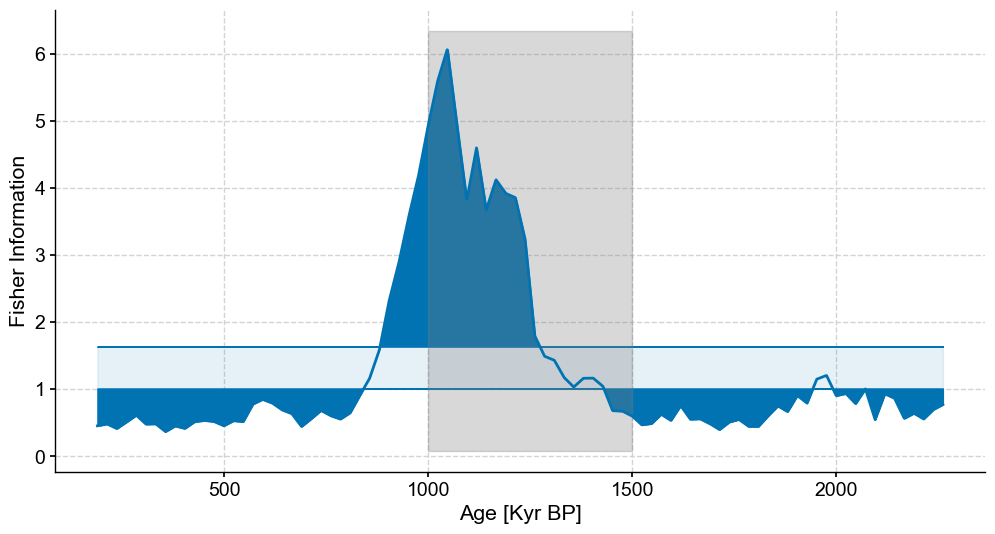

In [19]:
fig,ax = plt.subplots(figsize=(12,6))

lp_coarse.confidence_fill_plot(ax=ax,legend=False)
ylim = ax.get_ylim()
ax.fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
ax.set_ylabel('Fisher Information')
ax.set_xlabel('Age [Kyr BP]')

# Full figure

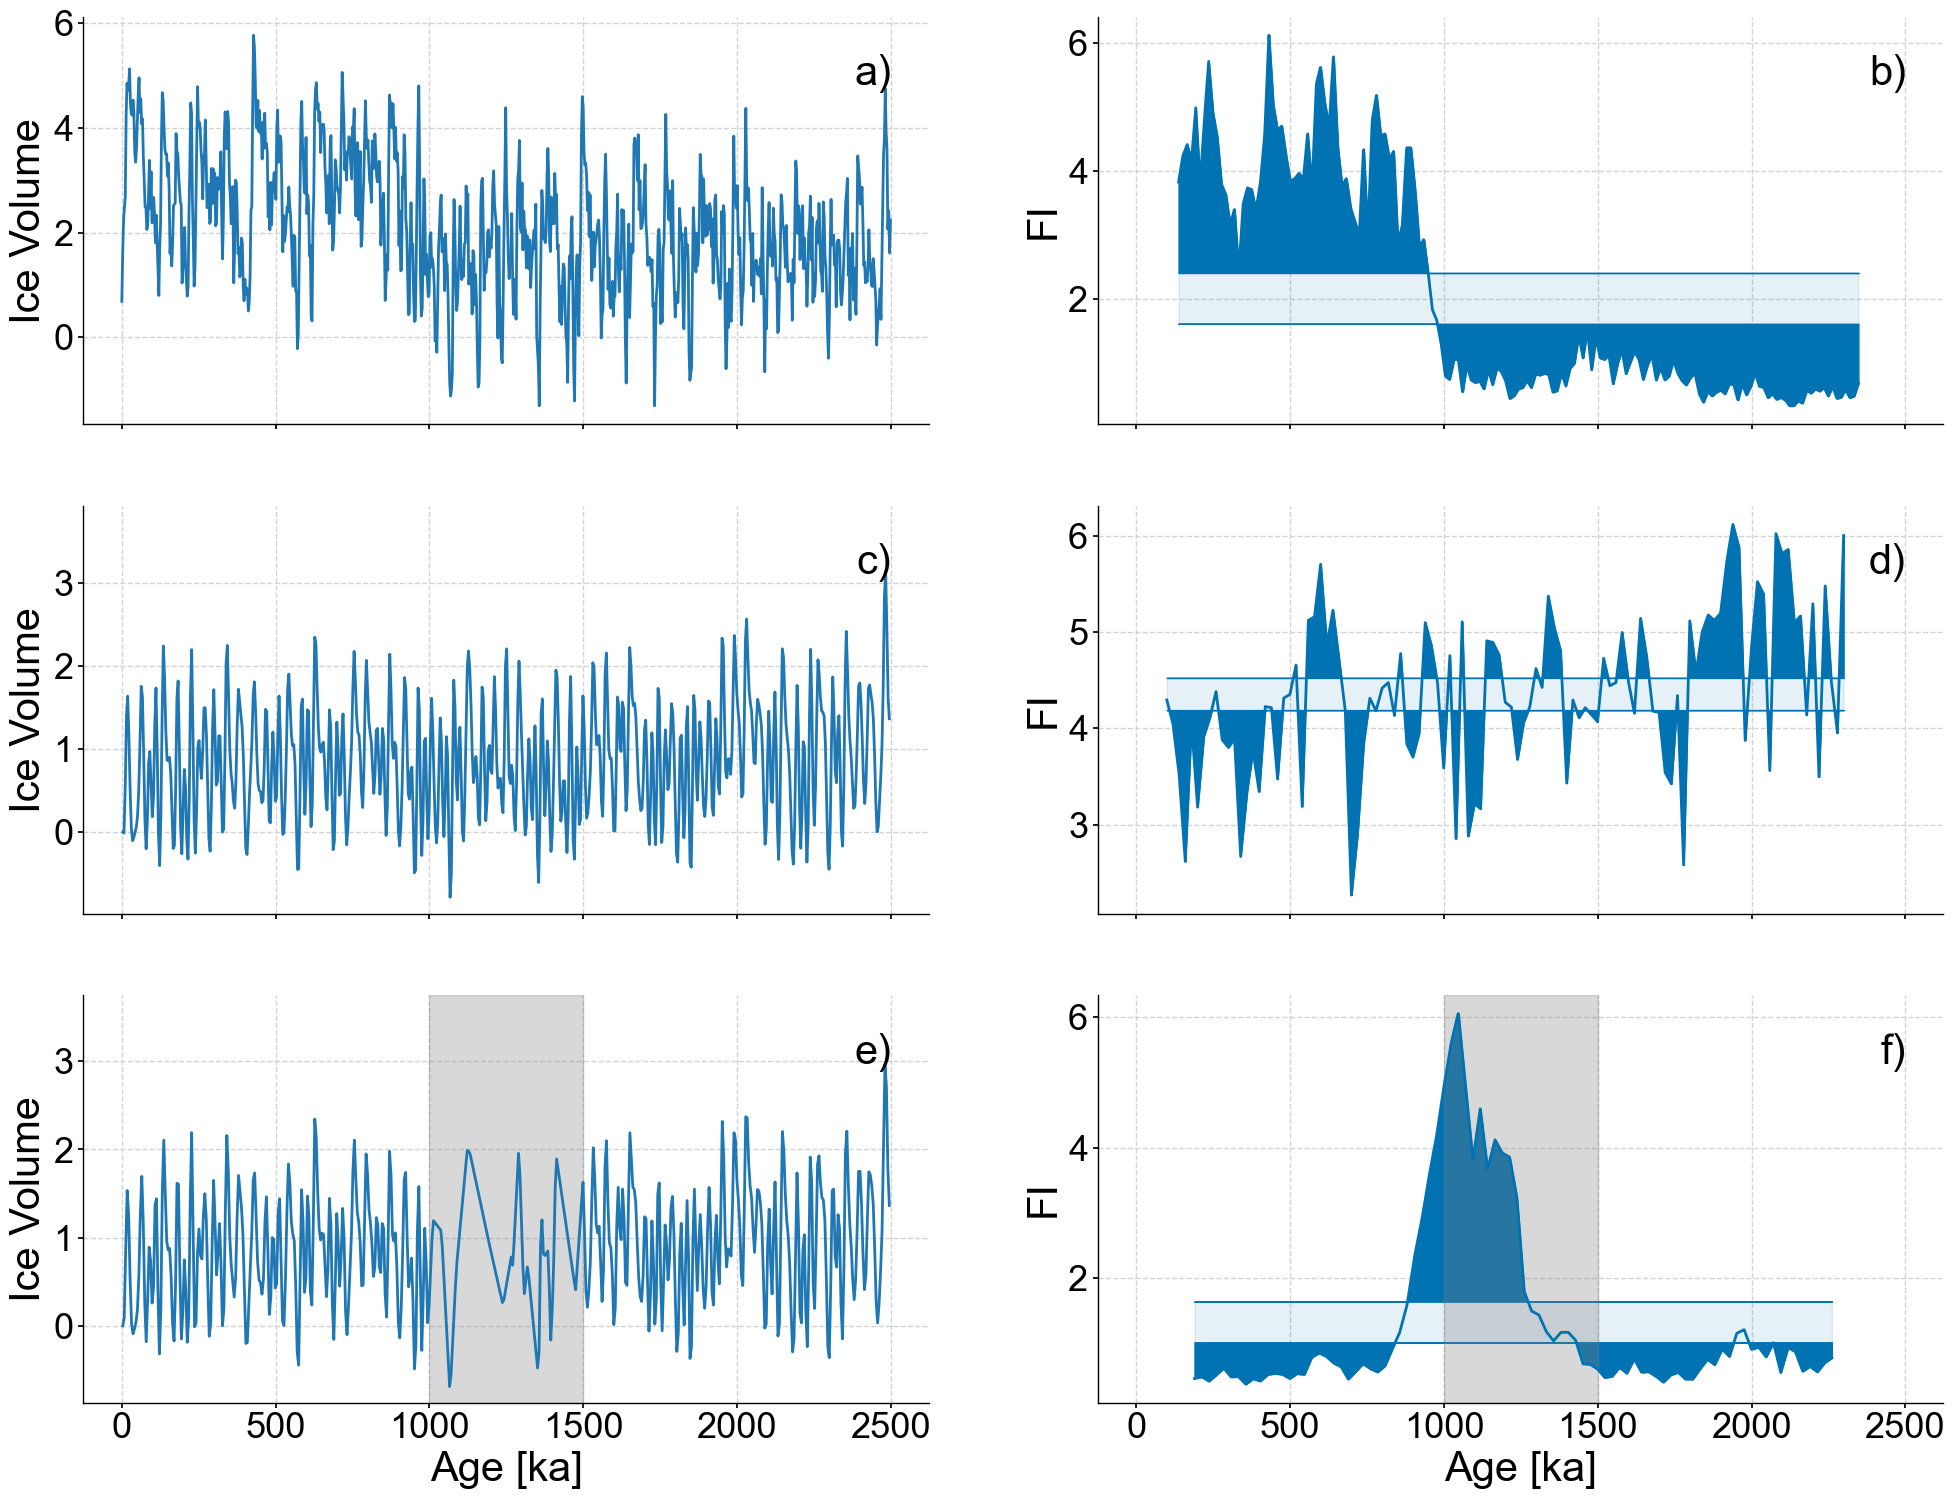

In [20]:
# Production figure

SMALL_SIZE = 26
MEDIUM_SIZE = 26
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,figsize=(24,18))

noisy_series_2.plot(ax=axes[0,0],legend=None,xlabel='')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
axes[0,0].legend(handles=[patch],loc='upper right')

lp_series_2.confidence_fill_plot(ax=axes[0,1],legend=None,xlabel='',ylabel='FI')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
axes[0,1].legend(handles=[patch],loc='upper right')

stable_series.plot(ax=axes[1,0],legend=None,xlabel='')
ylim=list(axes[1,0].get_ylim())
ylim[1]+=.6
axes[1,0].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='c)')
axes[1,0].legend(handles=[patch],loc='upper right')

lp_stable.confidence_fill_plot(ax=axes[1,1],legend=None,xlabel='',ylabel='FI')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='d)')
axes[1,1].legend(handles=[patch],loc='upper right')

coarse_series.plot(ax=axes[2,0],legend=None,xlabel='Age [ka]')
ylim=list(axes[2,0].get_ylim())
ylim[1]+=.6
axes[2,0].fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
axes[2,0].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='e)')
axes[2,0].legend(handles=[patch],loc='upper right')

lp_coarse.confidence_fill_plot(ax=axes[2,1],legend=None,ylabel='FI')
ylim=axes[2,1].get_ylim()
axes[2,1].fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
axes[2,1].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='f)')
axes[2,1].legend(handles=[patch],loc='upper right')